In [6]:
import numpy as np

import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import cm

from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import recall_score, precision_score, ConfusionMatrixDisplay, PrecisionRecallDisplay, RocCurveDisplay

from astroML.classification import GMMBayes
from astroML.datasets import fetch_rrlyrae_combined
from astroML.utils import split_samples

from scipy.stats import norm


from astropy.io import ascii
from astropy.io import fits
import os.path

from astropy.table import Table, join, MaskedColumn, vstack, Column

In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

print(tf.__version__)

from sklearn.metrics import ConfusionMatrixDisplay, PrecisionRecallDisplay
from sklearn.gaussian_process import GaussianProcessRegressor

from tqdm import tqdm

2.16.1


In [8]:
mpl.rcParams['figure.dpi'] = 150
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
plt.rc('legend', fontsize='x-small')
cmap = cm.get_cmap('viridis')

/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_24137/2837194893.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis')


In [9]:
data=Table.read('Stats_Table_For_Data_augmented_lcs_v2.fits')

data

sector_stitched=Table.read('Stats_Table_For_Sector_Stitched.fits')

data = vstack([data, sector_stitched])

data

name,Lit_Clst_Age,rms,std,MAD,sigmaG,skewness,von_neumann_ratio,J_Stetson,max_power,freq_at_max_power,n_peaks,ratio_of_power_at_high_v_low_freq,FAP,max_autocorrelation,time_of_max_autocorrelation,SumLSP_10_7_Day_Power,SumLSP_7_4_Day_Power,SumLSP_4_1_Day_Power,SumLSP_1_p5_Day_Power,Entropy
bytes17,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64[1],float64,float64,float64,float64,float64
NGC 5381,8.65,0.2022739754519168,0.00028663242586913503,0.00018204904335616945,0.00027032716740019386,-5.109964804222913e-12,0.00386747638646434,11.012043362402764,0.2956196136312983,2.1800000000000006,7,35.25172608498783,5.6489191125891904e-83,0.6090280071896582,0.5000039539129375,0.08840027872050202,0.551564524378355,1.1235926764590056,0.2938252007400544,0.00912773133976864
NGC 5381,8.65,0.12860581353173967,0.00029758624459087497,0.00018677990032528458,0.0002724429021247358,-1.4861178185896828e-11,0.0072174287439932296,11.19932586798964,0.2858757168806013,2.1800000000000006,2,22.58421369093873,3.1991008561289327e-38,0.35192202026737984,0.5000117633198897,0.08236173981181749,0.8858419453379427,2.1146489663557895,0.6387350704087281,0.009878216867509258
NGC 5381,8.65,0.2022739754519168,0.0002749497473011351,0.0001760566489865667,0.0002598061826987392,4.985244439169258e-12,0.008432348981660785,10.832836728495531,0.3321170484680969,2.1800000000000006,2,63.9392138272648,1.7081151810643954e-46,0.6090280071896582,0.5000039539129375,0.24075422793919207,1.6594671516063568,2.1257999401516057,0.448080689756279,-0.0007504855277406172
NGC 5381,8.65,0.13418989839761541,0.00029670974388146205,0.00018715823279225052,0.00027474567848145,-1.4819021191571437e-11,0.007902359972537888,11.215158743038272,0.3092047888317955,2.1900000000000004,2,22.086456566940438,3.976387179616506e-37,0.35367954438974186,0.4791779375589158,0.09887134140967274,1.1529494497686852,2.490978861040854,0.6349831324113722,0.006366704374634439
NGC 5381,8.65,0.17262428678829597,0.0002957994551170428,0.0001947926770065056,0.00028877667424492826,7.949348591748663e-12,0.007853282537324254,11.344726858798873,0.2823310089408097,2.1800000000000006,3,25.45485685062133,5.270363097162563e-33,0.44152498501025716,0.6875159881769832,0.06948436182961143,0.8943645304859869,2.617654265447661,0.8130747500049615,0.002130485780783362
NGC 5381,8.65,0.20342537128083304,0.0002732158088483212,0.00017971636228852894,0.0002662374500090785,4.074129139791262e-12,0.007349842456913631,10.283775613193056,0.3538975416671665,2.1800000000000006,4,36.69742716441359,2.390364865023084e-44,0.5316360879383262,0.43750944667317526,0.0949982493524582,0.4623089900428734,2.053662679896389,1.046635427882411,0.0028261693332049306
NGC 5381,8.65,0.2307399119235911,0.0002677956171043393,0.00018059586669483263,0.0002665594344778601,4.8205018650938374e-12,0.007782358681751355,10.123885193997234,0.3386046778402443,2.1900000000000004,6,44.498114854025175,9.393056151242283e-42,0.47518645396899706,0.4375085258229774,0.05300589586641587,0.29486004971296664,2.174814315902417,1.095353559280317,-0.0043037936123419135
NGC 5381,8.65,0.22077649622315093,0.00028736928263985265,0.00019529854088140564,0.0002865572846073615,3.3188360954961803e-12,0.008793630554351822,10.922918396661096,0.27925708595394183,2.1900000000000004,6,52.40948815416692,2.0673842635311304e-32,0.6002905113611597,0.5000039539129375,0.24813217870249696,1.2957295189420075,2.28049676322127,0.8465257783128015,0.007883061859175302
NGC 5381,8.65,0.21821100221255357,0.0002979377559200514,0.0002010363813400584,0.00029422255247299917,3.048307924578792e-12,0.00967834794471458,11.503733919463457,0.29776047325346133,0.22000000000000006,3,61.22050634304591,2.696162426828419e-35,0.60816054645364,0.5000039539129375,0.32120520102402084,2.126809469890936,2.186733635251189,0.8440061976224885,0.0003633584417250379


In [10]:
labels = ['Young', 'Old']
features=['rms', 'std','MAD','sigmaG','skewness','von_neumann_ratio','J_Stetson','max_power','freq_at_max_power',
          'ratio_of_power_at_high_v_low_freq','max_autocorrelation','time_of_max_autocorrelation', 'SumLSP_10_7_Day_Power',
          'SumLSP_7_4_Day_Power','SumLSP_4_1_Day_Power','SumLSP_1_p5_Day_Power', 'Entropy']
len(features)

17

In [15]:
def get_samples(data):
        # Define the range and size of the selection
        
    grouped=data.group_by('name')
    
    low = 0
    high = len(grouped.groups)  # Adjust this as needed
    size = 35  # Number of unique random numbers you want in each set

    # Generate the full range of possible numbers
    possible_numbers = np.arange(low, high)

    # Select the first set of numbers without replacement
    Validation_ints = np.random.choice(possible_numbers, size=size, replace=False)

    # Remove the selected numbers from the pool
    remaining_numbers = np.setdiff1d(possible_numbers, Validation_ints)

    # Select the second set of numbers without replacement from the remaining pool
    Test_ints = np.random.choice(remaining_numbers, size=size, replace=False)

    used_numbers = np.concatenate((Validation_ints, Test_ints))
    Training_ints = np.setdiff1d(possible_numbers, used_numbers)
    
    training_data_l=[]
    validation_data_l=[]
    test_data_l=[]

    for i in range(len(Training_ints)):
        training_data_l.append(grouped.groups[Training_ints[i]])

    training_data = vstack(training_data_l)

    for i in range(len(Validation_ints)):
        validation_data_l.append(grouped.groups[Validation_ints[i]])


    validation_data = vstack(validation_data_l)

    for i in range(len(Test_ints)):
        test_data_l.append(grouped.groups[Test_ints[i]])


    test_data = vstack(test_data_l)

    X_train=np.zeros((len(training_data), len(training_data.colnames)-4))

    for i in range(len(training_data)):
        X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i]    

    X_valid=np.zeros((len(validation_data), len(validation_data.colnames)-4))

    for i in range(len(validation_data)):
        X_valid[i]= validation_data['rms'][i], validation_data['std'][i], validation_data['MAD'][i], validation_data['sigmaG'][i], validation_data['skewness'][i], validation_data['von_neumann_ratio'][i], validation_data['J_Stetson'][i], validation_data['max_power'][i], validation_data['freq_at_max_power'][i], validation_data['ratio_of_power_at_high_v_low_freq'][i], validation_data['max_autocorrelation'][i], validation_data['time_of_max_autocorrelation'][i], validation_data['SumLSP_10_7_Day_Power'][i], validation_data['SumLSP_7_4_Day_Power'][i], validation_data['SumLSP_4_1_Day_Power'][i], validation_data['SumLSP_1_p5_Day_Power'][i], validation_data['Entropy'][i]    

    X_test=np.zeros((len(test_data), len(test_data.colnames)-4))

    for i in range(len(test_data)):
        X_test[i]= test_data['rms'][i], test_data['std'][i], test_data['MAD'][i], test_data['sigmaG'][i], test_data['skewness'][i], test_data['von_neumann_ratio'][i], test_data['J_Stetson'][i], test_data['max_power'][i], test_data['freq_at_max_power'][i], test_data['ratio_of_power_at_high_v_low_freq'][i], test_data['max_autocorrelation'][i], test_data['time_of_max_autocorrelation'][i], test_data['SumLSP_10_7_Day_Power'][i], test_data['SumLSP_7_4_Day_Power'][i], test_data['SumLSP_4_1_Day_Power'][i], test_data['SumLSP_1_p5_Day_Power'][i], test_data['Entropy'][i]    

    y_train=np.zeros((len(training_data)))

    for i in range(len(training_data)):
        if training_data['Lit_Clst_Age'][i] < np.median(training_data['Lit_Clst_Age']):
            y_train[i]=0
        else:
            y_train[i]=1   
    
    y_valid=np.zeros((len(validation_data)))

    for i in range(len(validation_data)):
        if validation_data['Lit_Clst_Age'][i] < np.median(validation_data['Lit_Clst_Age']):
            y_valid[i]=0
        else:
            y_valid[i]=1
            
    y_test=np.zeros((len(test_data)))

    for i in range(len(test_data)):
        if test_data['Lit_Clst_Age'][i] < np.median(test_data['Lit_Clst_Age']):
            y_test[i]=0
        else:
            y_test[i]=1

    return X_train, X_valid, X_test, y_train, y_valid, y_test

In [17]:
def run_evaluate_model(X_train, X_valid, X_test, y_train, y_valid, y_test):
    normalizer = layers.Normalization()
    normalizer.adapt(X_train)

    model = keras.Sequential([
        normalizer,
        layers.Dense(1000, activation='relu'),
        layers.Dropout(0.1),
        layers.Dense(500, activation='relu'),
        layers.Dropout(0.1),
        layers.Dense(200, activation='relu'),
        layers.Dropout(0.05),
        layers.Dense(100, activation='relu'),
        layers.Dropout(0.05),
        layers.Dense(100, activation='relu'),
        layers.Dense(50, activation='relu'),
        layers.Dropout(0.05),
        layers.Dense(50, activation='relu'),
        layers.Dense(1, activation='sigmoid') # now this is a probability!
        ])

    model.compile(
        # Optimizer
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        # Loss function to minimize
        loss=keras.losses.BinaryCrossentropy(), # use this loss function for binary classification
        # List of metrics to monitor
        metrics=[keras.metrics.Precision(name='precision'), keras.metrics.Recall(name='recall')],
    )

    callbacks = [
        keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss",
            factor=0.1,
            patience=20,
            verbose=0,
            min_delta=1e-5,
        ),
        keras.callbacks.EarlyStopping(
            monitor="val_loss",
            min_delta=1e-5,
            patience=20,
            verbose=0,
        )
    ]

    history = model.fit(
        X_train,
        y_train,
        batch_size=4096,
        epochs=500,
        validation_data=(X_valid, y_valid),
        callbacks=callbacks,
        verbose=0
    )
    
    
    predictions_probability = model.predict(X_test).reshape(-1)
    # convert to class prediction with 50% threshold
    predictions_class = predictions_probability > 0.5
    
    recall = recall_score(y_test, predictions_class)
    precision = precision_score(y_test, predictions_class)
    
    return recall, precision



In [3]:
def Run_all(data):
    X_train, X_valid, X_test, y_train, y_valid, y_test = get_samples(data)
    
    recall, precision = run_evaluate_model(X_train, X_valid, X_test, y_train, y_valid, y_test)
    
    return recall, precision

In [1]:
Run_all(data)

NameError: name 'Run_all' is not defined

In [18]:
n_trials=100

recall_results=np.zeros(n_trials)
precission_results=np.zeros(n_trials)


for i in range(n_trials):
    recall_results[i], precission_results[i] = Run_all(data)

/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_24137/1640273581.py:49: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_24137/1640273581.py:49: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_24137/1640273581.py:49: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_24137/1640273581.py:49: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_24137/1640273581.py:49: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_24137/1640273581.py:49: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_24137/1640273581.py:49: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_24137/1640273581.py:49: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_24137/1640273581.py:49: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_24137/1640273581.py:49: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_24137/1640273581.py:49: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_24137/1640273581.py:49: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_24137/1640273581.py:49: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_24137/1640273581.py:49: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_24137/1640273581.py:49: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_24137/1640273581.py:49: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_24137/1640273581.py:49: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_24137/1640273581.py:49: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

226/226 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_24137/1640273581.py:49: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_24137/1640273581.py:49: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_24137/1640273581.py:49: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_24137/1640273581.py:49: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_24137/1640273581.py:49: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_24137/1640273581.py:49: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_24137/1640273581.py:49: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_24137/1640273581.py:49: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_24137/1640273581.py:49: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_24137/1640273581.py:49: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_24137/1640273581.py:49: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_24137/1640273581.py:49: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_24137/1640273581.py:49: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_24137/1640273581.py:49: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_24137/1640273581.py:49: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_24137/1640273581.py:49: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_24137/1640273581.py:49: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_24137/1640273581.py:49: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_24137/1640273581.py:49: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_24137/1640273581.py:49: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_24137/1640273581.py:49: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_24137/1640273581.py:49: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_24137/1640273581.py:49: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_24137/1640273581.py:49: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_24137/1640273581.py:49: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_24137/1640273581.py:49: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_24137/1640273581.py:49: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_24137/1640273581.py:49: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_24137/1640273581.py:49: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_24137/1640273581.py:49: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_24137/1640273581.py:49: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_24137/1640273581.py:49: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_24137/1640273581.py:49: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_24137/1640273581.py:49: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_24137/1640273581.py:49: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_24137/1640273581.py:49: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_24137/1640273581.py:49: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_24137/1640273581.py:49: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_24137/1640273581.py:49: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_24137/1640273581.py:49: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_24137/1640273581.py:49: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_24137/1640273581.py:49: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_24137/1640273581.py:49: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_24137/1640273581.py:49: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_24137/1640273581.py:49: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_24137/1640273581.py:49: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_24137/1640273581.py:49: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_24137/1640273581.py:49: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_24137/1640273581.py:49: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_24137/1640273581.py:49: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_24137/1640273581.py:49: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_24137/1640273581.py:49: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_24137/1640273581.py:49: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_24137/1640273581.py:49: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_24137/1640273581.py:49: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_24137/1640273581.py:49: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_24137/1640273581.py:49: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_24137/1640273581.py:49: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_24137/1640273581.py:49: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_24137/1640273581.py:49: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_24137/1640273581.py:49: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_24137/1640273581.py:49: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_24137/1640273581.py:49: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_24137/1640273581.py:49: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_24137/1640273581.py:49: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_24137/1640273581.py:49: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_24137/1640273581.py:49: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_24137/1640273581.py:49: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_24137/1640273581.py:49: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_24137/1640273581.py:49: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_24137/1640273581.py:49: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_24137/1640273581.py:49: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_24137/1640273581.py:49: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_24137/1640273581.py:49: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_24137/1640273581.py:49: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_24137/1640273581.py:49: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_24137/1640273581.py:49: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_24137/1640273581.py:49: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_24137/1640273581.py:49: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_24137/1640273581.py:49: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_24137/1640273581.py:49: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_24137/1640273581.py:49: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


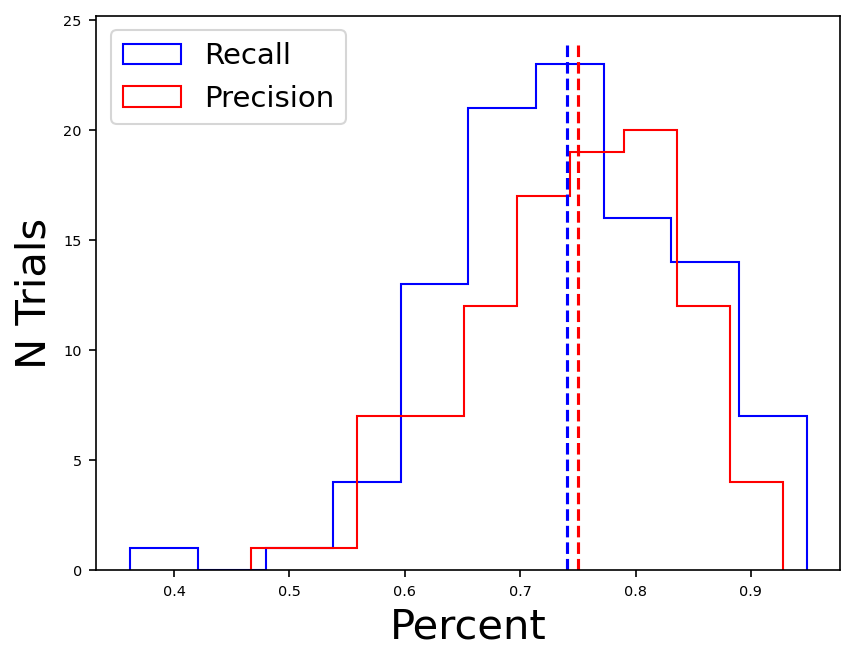

In [34]:
plt.hist(recall_results, bins=10, histtype='step', color='b', label='Recall')
plt.hist(precission_results, bins=10, histtype='step', color='r', label='Precision')
plt.vlines(x=np.median(recall_results), ymin=0, ymax=24, linestyle='--', color='b')
plt.vlines(x=np.median(precission_results), ymin=0, ymax=24, linestyle='--', color='r')
plt.ylabel('N Trials', fontsize=20)
plt.xlabel('Percent', fontsize=20)
plt.legend(fontsize=14)
plt.savefig('Dist_for_CNN.pdf', bbox_inches='tight', format='pdf')

In [23]:
np.percentile(recall_results, [16,50,84])

array([0.63825319, 0.74097434, 0.85982399])

In [27]:
np.percentile(precission_results, [16,50,84])

array([0.65286267, 0.75049192, 0.83343685])

In [35]:
np.percentile(recall_results, [50])

array([0.74097434])

In [36]:
np.percentile(recall_results, [50]) - np.percentile(recall_results, [16])

array([0.10272115])

In [37]:
np.percentile(recall_results, [84]) - np.percentile(recall_results, [50])

array([0.11884965])

In [30]:
np.percentile(precission_results, [50])

array([0.75049192])

In [29]:
np.percentile(precission_results, [50]) - np.percentile(precission_results, [16])

array([0.09762925])

In [28]:
np.percentile(precission_results, [84]) - np.percentile(precission_results, [50])

array([0.08294493])